In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math

In [61]:
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Data Gen

In [32]:
# g : R^2 -> R
# Here, each x \in X are \in R^2
def true_g(X):
    return np.sum(X, axis=1)
    # return np.sum(np.square(X), axis=1)
    # return np.where(np.linalg.norm(X, axis=1) < 4, 0, 1)

# Given g, each x \in X are \in R^3
def true_f(g, X):
    g_result = g(X[:,:2])
    return g_result * (1 - X[:,2]) + (-1 * g_result) * X[:,2]

In [33]:
# Number of training points will be split_sizes[0] + split_sizes[1]
def get_train_data(split_sizes):
    n0 = split_sizes[0]
    n1 = split_sizes[1]

    X1_01 = np.around(np.random.uniform(0, 5, size=(n0,2)), 6)
    X1_2 = np.zeros((n0, 1))
    X1 = np.hstack((X1_01, X1_2))

    X2_01 = np.around(np.random.uniform(0, 5, size=(n1,2)), 6)
    X2_2 = np.ones((n1, 1))
    X2 = np.hstack((X2_01, X2_2))

    X_train = np.vstack((X1, X2))
    y_train = true_f(true_g, X_train)
    return X_train, y_train

X_train, y_train = get_train_data([5000,5000])
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

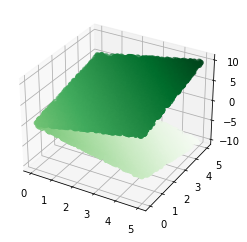

In [34]:
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,0], X_train[:,1], y_train, c=y_train, cmap='Greens');

## Model

In [57]:
# Toggle this flag if we want to embed the 
embed_flag = False

class FeedForward(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layers_sizes, output_size):
        super(FeedForward, self).__init__()

        self.embeddings = nn.Embedding(2, 1)
        self.linears = nn.ModuleList([nn.Linear(input_size, hidden_layers_sizes[0])])
        self.linears.extend([nn.Linear(hidden_layers_sizes[i], hidden_layers_sizes[i+1]) \
            for i in range(num_hidden_layers-1)])
        self.linears.append(nn.Linear(hidden_layers_sizes[-1], output_size))
        self.relu = nn.ReLU()

    def forward(self, x):
        # Need to embed the third column of all of x
        if embed_flag:
            with torch.no_grad():
                col = self.embeddings(x[:,2].long())
                col = col.float()
            x = torch.cat((x[:,:2],col), dim=1)

        for fc in self.linears[:-1]:
            x = self.relu(fc(x))
        return self.linears[-1](x)

In [58]:
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=20)
model = FeedForward(X_train[0].shape[0], 3, [5,8,4], 1)

Epoch 0/200, Loss: 35.894
Epoch 1/200, Loss: 26.449
Epoch 2/200, Loss: 29.475
Epoch 3/200, Loss: 30.140
Epoch 4/200, Loss: 27.399
Epoch 5/200, Loss: 34.545
Epoch 6/200, Loss: 19.745
Epoch 7/200, Loss: 30.318
Epoch 8/200, Loss: 28.747
Epoch 9/200, Loss: 34.816
Epoch 10/200, Loss: 32.969
Epoch 11/200, Loss: 30.036
Epoch 12/200, Loss: 34.572
Epoch 13/200, Loss: 29.904
Epoch 14/200, Loss: 21.462
Epoch 15/200, Loss: 39.806
Epoch 16/200, Loss: 30.345
Epoch 17/200, Loss: 27.966
Epoch 18/200, Loss: 29.289
Epoch 19/200, Loss: 37.803
Epoch 20/200, Loss: 27.953
Epoch 21/200, Loss: 33.952
Epoch 22/200, Loss: 30.715
Epoch 23/200, Loss: 27.709
Epoch 24/200, Loss: 30.611
Epoch 25/200, Loss: 36.409
Epoch 26/200, Loss: 27.615
Epoch 27/200, Loss: 21.057
Epoch 28/200, Loss: 28.128
Epoch 29/200, Loss: 30.679
Epoch 30/200, Loss: 30.778
Epoch 31/200, Loss: 25.782
Epoch 32/200, Loss: 26.398
Epoch 33/200, Loss: 28.678
Epoch 34/200, Loss: 26.708
Epoch 35/200, Loss: 30.293
Epoch 36/200, Loss: 20.175
Epoch 37/20

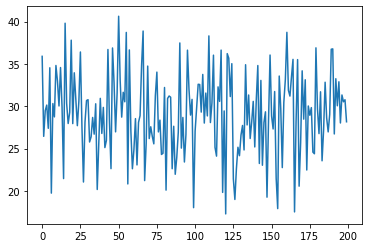

In [59]:
# criterion = nn.BCEWithLogitsLoss() // Uncomment this if y is binary value.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
loss_values = []
num_epochs = 200
for epoch in range(num_epochs):
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        labels = torch.unsqueeze(labels, 1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        # output = (outputs > 0.5).float()
        # correct += (output == labels).float().sum()

    # acc = correct / len(train_data)
    print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.3f}") #, Accuracy: {acc:.3f}")
    loss_values.append(loss.item())

plt.plot(np.array(np.arange(0, num_epochs)), loss_values)

In [ ]:
print(model(X_train[:10]))

In [ ]:
print(y_train[:10])